# Visualizing Max and Min Effect Datasets
*April 2020* - J. Nathan Matias

This R script takes data generated by [selecting_upworthy_archive_packages.py.ipynb](selecting_upworthy_archive_packages.py.ipynb) and generates charts that illustrate the range of effect sizes in the datasets.

In [16]:
library(ggplot2)
library(plm)
set.seed(253468449)

In [8]:
max.packages.df <- read.csv("upworthy_archive_exploratory_max_effect_size_dataset.csv")
min.packages.df <- read.csv("upworthy_archive_exploratory_min_effect_size_dataset.csv")
headlines.df <- read.csv("headlines.csv")

## Show Example Rows

Notice that the rows are similar to the data you used in the [headline experiment assignment](https://github.com/natematias/design-governance-experiments/tree/master/assignments/1-headline-experiment). Each row is a viewer:
* **clickability_test_id** (the test number)
* **headline_number**: this is the reference to the specific headline in the headlines CSV
* **has_treatment**: this is 1 if the headline includes a notable person's name name and 0 if it doesn't
* **clicked**: whether that viewer clicked on the package or not 

In [3]:
head(max.packages.df)

clickability_test_id,headline_index,has_treatment,clicked
546e009a9ad54ec65b00004b,7,1,1
546e009a9ad54ec65b00004b,7,1,1
546e009a9ad54ec65b00004b,7,1,1
546e009a9ad54ec65b00004b,7,1,1
546e009a9ad54ec65b00004b,7,1,1
546e009a9ad54ec65b00004b,7,1,1


## Show Results From A Single Test

In [4]:
single.test.df <- subset(max.packages.df, 
                         clickability_test_id==max.packages.df$clickability_test_id[1])


notable.person.headline <- as.character(subset(headlines.df, headline_index==unique(subset(single.test.df, has_treatment==1)$headline_index))$headline)
no.notable.person.headline <- as.character(subset(headlines.df, headline_index==unique(subset(single.test.df, has_treatment==0)$headline_index))$headline)

summary(result.lm <- lm(clicked ~ has_treatment, 
                        data=single.test.df))
# generate a dataframe with a row for whether 
# the headline includes the name of a notable person
estimate.df <- data.frame(has_treatment=c(0,1))

# use the predict() method with the result object
# to create estimates and confidence intervals for each 
preds.df <- data.frame(predict(result.lm, estimate.df, se.fit=TRUE, interval="confidence")$fit)

estimate.df$estimate <- preds.df$fit
estimate.df$estimate.lwr <- preds.df$lwr
estimate.df$estimate.upr <- preds.df$upr

print("Estimates and confidence intervals for each arm.")
estimate.df


Call:
lm(formula = clicked ~ has_treatment, data = single.test.df)

Residuals:
     Min       1Q   Median       3Q      Max 
-0.01379 -0.01379 -0.00587 -0.00587  0.99413 

Coefficients:
              Estimate Std. Error t value Pr(>|t|)    
(Intercept)   0.005868   0.001452   4.040 5.38e-05 ***
has_treatment 0.007926   0.002058   3.852 0.000118 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.09852 on 9166 degrees of freedom
Multiple R-squared:  0.001616,	Adjusted R-squared:  0.001507 
F-statistic: 14.83 on 1 and 9166 DF,  p-value: 0.0001182


[1] "Estimates and confidence intervals for each arm."


has_treatment,estimate,estimate.lwr,estimate.upr
0,0.00586829,0.003021094,0.008715485
1,0.01379461,0.010936839,0.016652388


In [ ]:
options(repr.plot.width=7, repr.plot.height=3)
ggplot(estimate.df, aes(factor(estimate.df$has_treatment), estimate)) +
    geom_point() +
    geom_errorbar(ymin=estimate.df$estimate.lwr, ymax=estimate.df$estimate.upr, width=0.15) +
    scale_x_discrete(breaks=c(0,1), labels=c("No Notable Person", "Notable Person")) +
    scale_y_continuous(limits=c(0,max(estimate.df$estimate.upr)), 
                       breaks=(seq(0,max(estimate.df$estimate.upr), 0.005)),labels = scales::percent) +
    theme_bw() +
    theme(plot.title = element_text(size=13, face="bold"),
          axis.title.x =element_text(size=10, hjust = -0.01, color = "#333333")) +
    coord_flip() + ## This line converts the vertical plot to a horizontal plot
    xlab("") +
    ylab(paste("Click-through rate\n\n", 
               "A/B Test Conducted by Upworthy (n=", 
               nrow(single.test.df), ") \n",
               "Notable Person Headline: ", "\n  ",
               notable.person.headline, "\n",
               "Comparison Headline:", "\n",
               no.notable.person.headline, "\n",
               sep=""))

# Analyze Every Test

This function goes through every unique test and returns a dataframe with the estimate and upper/lower confidence intervals for every test.

In [9]:
analyze.all.tests <- function(df){
    all.tests.df <- data.frame(test.id=character(0), estimate = numeric(0), 
                             estimate.upr = numeric(0), estimate.lwr = numeric(0),
                             p.value = numeric(0))

    for(test.id in unique(df$clickability_test_id)){
        test.viewers <- subset(df, clickability_test_id==test.id)
        summary(result.lm <- lm(clicked ~ has_treatment, data=test.viewers))

        lm.coef <- coef(summary(result.lm))
        estimate.df <- data.frame(
            test.id      = test.id,
            estimate     = lm.coef['has_treatment',][['Estimate']],
            estimate.upr = lm.coef['has_treatment',][['Estimate']] + 1.96 * lm.coef['has_treatment',][['Std. Error']],
            estimate.lwr = lm.coef['has_treatment',][['Estimate']] - 1.96 * lm.coef['has_treatment',][['Std. Error']],
            p.value      = lm.coef['has_treatment',][['Pr(>|t|)']])    
        all.tests.df <- rbind(all.tests.df, estimate.df)
    }
    print(paste(nrow(all.tests.df), "total tests analyzed"))
    all.tests.df
}

In [10]:
max.tests.results.df <- analyze.all.tests(max.packages.df)
min.tests.results.df <- analyze.all.tests(min.packages.df)

[1] "718 total tests analyzed"
[1] "718 total tests analyzed"


## Illustrate Tests
The following function produces a "caterpiller plot" of multiple experiment results, sorted from high to low.

In [11]:
illustrate.result <- function(result.df, viewer.df,
                              plot.title,
                              characteristic_label,
                              no_characteristic_label){

    ggplot(result.df, aes(reorder(test.id, -estimate), estimate)) +
        geom_hline(yintercept=0, color="#aaaaaa") +
        geom_hline(yintercept = mean(result.df$estimate),
                   color="#ffaa66", 
                   linetype="dashed") +
        geom_errorbar(ymin=result.df$estimate.lwr, 
                      ymax=result.df$estimate.upr, 
                      width=0.15, 
                      color="#666666") +
        geom_point(color="#333333", size=0.5) +
        theme_bw() + 
        theme(axis.text.x  = element_blank(),
              axis.ticks.x = element_blank(),
              axis.title.x = element_text(hjust=0, size=10),
              panel.grid.major = element_blank(), 
              panel.grid.minor = element_blank()) +
        scale_y_continuous(breaks=seq(-0.06, 0.06, 0.01), 
                           limits=c(-0.055, 0.055)) +
        xlab(paste("Headline A/B tests conducted by Upworthy that included",
                   characteristic_label,
                   " versus", "\n", "a headline with ", 
                   no_characteristic_label, 
                   " (n=", nrow(result.df), " tests and ",
                   prettyNum(nrow(min.packages.df), big.mark=","), 
                   " viewers)", "\n",
                   "Dashed line represents the mean of all estimates.", 
                   sep="")) +
        ggtitle(plot.title)
}

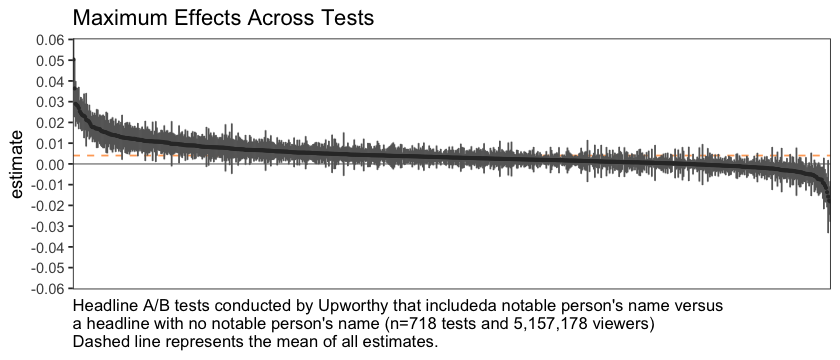

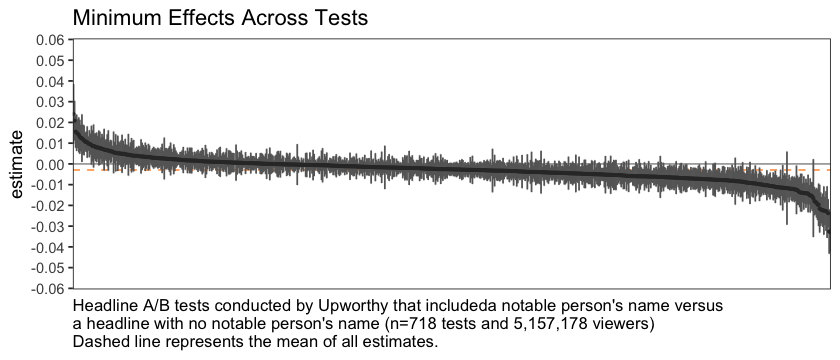

In [12]:
illustrate.result(max.tests.results.df, 
                  max.packages.df,
                  "Maximum Effects Across Tests", 
                  "a notable person's name",
                  "no notable person's name")

illustrate.result(min.tests.results.df, 
                  min.packages.df,
                  "Minimum Effects Across Tests",
                  "a notable person's name",
                  "no notable person's name")

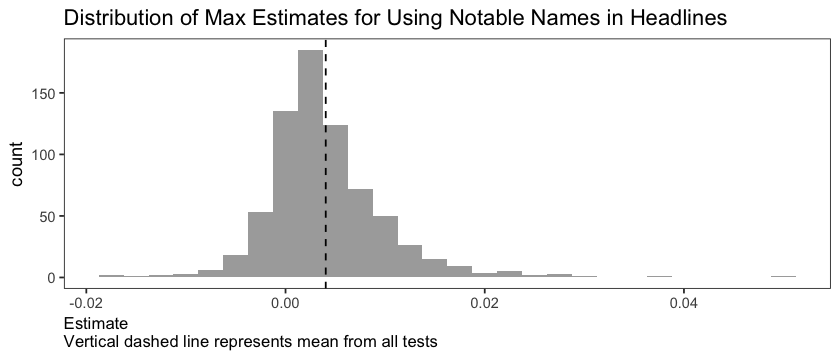

In [13]:
ggplot(max.tests.results.df, aes(estimate)) +
    geom_histogram(binwidth=0.0025, fill="#aaaaaa") +
        theme_bw() + 
        theme(axis.title.x = element_text(hjust=0, size=10),
              panel.grid.major = element_blank(), 
              panel.grid.minor = element_blank()) +
    geom_vline(xintercept=mean(max.tests.results.df$estimate), 
               color="black", linetype="dashed") +
    ggtitle("Distribution of Max Estimates for Using Notable Names in Headlines") +
    xlab(paste("Estimate", "\n", "Vertical dashed line represents mean from all tests", sep=""))

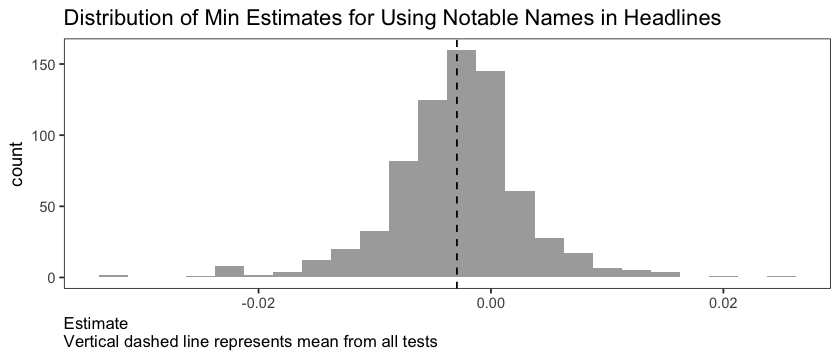

In [14]:
ggplot(min.tests.results.df, aes(estimate)) +
    geom_histogram(binwidth=0.0025, fill="#aaaaaa") +
        theme_bw() + 
        theme(axis.title.x = element_text(hjust=0, size=10),
              panel.grid.major = element_blank(), 
              panel.grid.minor = element_blank()) +
    geom_vline(xintercept=mean(min.tests.results.df$estimate), 
               color="black", linetype="dashed") +
    ggtitle("Distribution of Min Estimates for Using Notable Names in Headlines") +
    xlab(paste("Estimate", "\n", "Vertical dashed line represents mean from all tests", sep=""))

# Fixed Effects Model

In [21]:
summary(plm(clicked ~ has_treatment,
            index="clickability_test_id",
            model="within",
            data=max.packages.df))

Oneway (individual) effect Within Model

Call:
plm(formula = clicked ~ has_treatment, data = max.packages.df, 
    model = "within", index = "clickability_test_id")

Unbalanced Panel: n = 718, T = 1392-22066, N = 5152156

Residuals:
      Min.    1st Qu.     Median    3rd Qu.       Max. 
-0.0768528 -0.0131777 -0.0081691 -0.0047532  1.0010961 

Coefficients:
                Estimate Std. Error t-value  Pr(>|t|)    
has_treatment 3.8510e-03 8.8879e-05  43.329 < 2.2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Total Sum of Squares:    52413
Residual Sum of Squares: 52394
R-Squared:      0.00036431
Adj. R-Squared: 0.00022499
F-statistic: 1877.42 on 1 and 5151437 DF, p-value: < 2.22e-16

In [22]:
summary(plm(clicked ~ has_treatment,
            index="clickability_test_id",
            model="within",
            data=min.packages.df))

Oneway (individual) effect Within Model

Call:
plm(formula = clicked ~ has_treatment, data = min.packages.df, 
    model = "within", index = "clickability_test_id")

Unbalanced Panel: n = 718, T = 1299-22036, N = 5157178

Residuals:
      Min.    1st Qu.     Median    3rd Qu.       Max. 
-0.0763156 -0.0148353 -0.0094237 -0.0061094  1.0005564 

Coefficients:
                 Estimate  Std. Error t-value  Pr(>|t|)    
has_treatment -2.7293e-03  9.4066e-05 -29.015 < 2.2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Total Sum of Squares:    58808
Residual Sum of Squares: 58798
R-Squared:      0.00016324
Adj. R-Squared: 2.4018e-05
F-statistic: 841.867 on 1 and 5156459 DF, p-value: < 2.22e-16